In [1]:
from PIL import Image
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import os

In [2]:
batch_size = 64
learning_rate = 0.0001
num_epoch = 50

In [3]:
SEM_root = "/data/jhkim/samsung/AI_challenge_data/Train/SEM/"
depth_root = "/data/jhkim/samsung/AI_challenge_data/Train/Depth/"
test_root = "/data/jhkim/samsung/AI_challenge_data/Test/SEM/"

train_SEMimglist = os.listdir("/data/jhkim/samsung/AI_challenge_data/Train/SEM")
train_depthimglist = os.listdir("/data/jhkim/samsung/AI_challenge_data/Train/Depth")
test_SEMimglist = os.listdir("/data/jhkim/samsung/AI_challenge_data/Test/SEM")

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
trans_wo_Norm = transforms.ToTensor()

class img_dataset(Dataset):
    def __init__(self, file_list, transform, SEM_path):
        self.file_list = file_list
        self.transform = transform
        self.path = SEM_path
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(self.path + img_path)
        img_transformed = self.transform(img)

        return img_transformed, img_path

train_dataset = img_dataset(file_list = train_SEMimglist, transform=trans, SEM_path=SEM_root)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = img_dataset(file_list = test_SEMimglist, transform=trans, SEM_path=test_root)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

batch_iterator = iter(train_dataloader)
images = next(batch_iterator)

In [4]:
#input size: 1 x 66 x 45

#Autoencoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,4,3,padding=1),                            # batch x 16 x 66 x 45
                        nn.ReLU(),
                        nn.BatchNorm2d(4),
                        nn.Conv2d(4,8,3,padding=1),                           # batch x 32 x 66 x 45
                        nn.ReLU(),
                        nn.BatchNorm2d(8),
                        nn.Conv2d(8,16,3,padding=1),                           # batch x 32 x 66 x 45
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.MaxPool2d(2,2)                                       # batch x 64 x 33 x 22
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(16,32,3,padding=1),                          # batch x 128 x 33 x 22
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(32,64,3,padding=1),                         # batch x 256 x 16 x 11
                        nn.ReLU()
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,4,2,1,(1,0)),                    # batch x 128 x 33 x 22
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,16,3,1,1),                       # batch x 64 x 33 x 22
                        nn.ReLU(),
                        nn.BatchNorm2d(16)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(16,4,3,1,1),                        # batch x 16 x 33 x 22
                        nn.ReLU(),
                        nn.BatchNorm2d(4),
                        nn.ConvTranspose2d(4,1,4,2,1,(0,1)),                       # batch x 1 x 66 x 45
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,64,16,11)
        out = self.layer1(out)
        out = self.layer2(out)
        return out


In [5]:
#Loss function & Optimizer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

encoder = Encoder().to(device)
decoder = Decoder().to(device)

#To make end-to-end training!! concat parameters
parameters = list(encoder.parameters())+ list(decoder.parameters())

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

cuda:0


In [6]:
# Train
'''
try:
    encoder, decoder = torch.load('./model/conv_autoencoder.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass
'''

for i in range(num_epoch):
    tot_loss = 0
    cnt = 0
    for j, (image, img_path) in enumerate(train_dataloader):
        optimizer.zero_grad()
        image = image.to(device)
        
        output = encoder(image)
        output = decoder(output)
        
        target_img_list = []
        for k in range(len(img_path)):
            target_img_path = img_path[k][:-9]+'.png'
            target_img = Image.open(depth_root + target_img_path)
            target_img = trans_wo_Norm(target_img)
            target_img = target_img.to(device)
            target_img_list.append(target_img)
        target = torch.stack(target_img_list, dim=0)

        loss = loss_func(output,target)
        loss.backward()
        optimizer.step()
        tot_loss += loss.item()
        cnt += 1
    print("epoch: {}    Loss: {}".format(i, tot_loss/cnt))
    #if j % 10 == 0:
torch.save([encoder,decoder],'./model/conv_autoencoder.pkl')
print(loss)

epoch: 0    Loss: 0.02825696626752615
epoch: 1    Loss: 0.0057926330007612705
epoch: 2    Loss: 0.004322587491199374
epoch: 3    Loss: 0.0033134591270238163
epoch: 4    Loss: 0.0025954935234040024
epoch: 5    Loss: 0.0020718562122434376
epoch: 6    Loss: 0.001557851834781468
epoch: 7    Loss: 0.0013182973697781562
epoch: 8    Loss: 0.0012064168782904745
epoch: 9    Loss: 0.0010340661894530057
epoch: 10    Loss: 0.0008454171625897288
epoch: 11    Loss: 0.0007734709505923092
epoch: 12    Loss: 0.0007284317012876272
epoch: 13    Loss: 0.0006913693349808454
epoch: 14    Loss: 0.0006492676634341478
epoch: 15    Loss: 0.0005645904331468046
epoch: 16    Loss: 0.0003356123345438391
epoch: 17    Loss: 0.0002940500009804964
epoch: 18    Loss: 0.0002777069920906797
epoch: 19    Loss: 0.00026661266344599427
epoch: 20    Loss: 0.00025742563439998777
epoch: 21    Loss: 0.0002495467814384028
epoch: 22    Loss: 0.0002428665763232857
epoch: 23    Loss: 0.0002376344823744148
epoch: 24    Loss: 0.0002317

torch.Size([64, 66, 45])


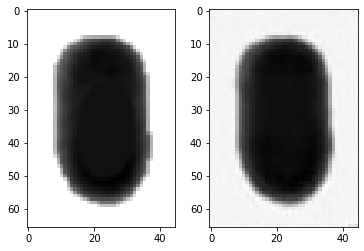

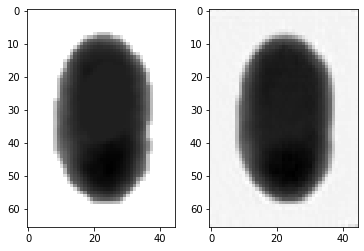

In [7]:
#Check

out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(2):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(target[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

In [8]:
#test
batch_size = 1
output_path = "/data/jhkim/samsung/output/"
cnt = 0

with torch.no_grad():
    for j,(image,img_path) in enumerate(test_dataloader):
       
        image = image.to(device)
        output = encoder(image)
        output = decoder(output)
        torchvision.utils.save_image(output, output_path+img_path[0])
        cnt += 1
print("{} image saved in {}".format(cnt, output_path))

5000 image saved in /data/jhkim/samsung/output/


torch.Size([66, 45])


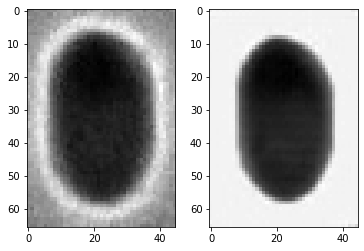

In [9]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

plt.subplot(1,2,1)
plt.imshow(torch.squeeze(image).cpu().numpy(),cmap='gray')
plt.subplot(1,2,2)
plt.imshow(out_img.numpy(),cmap='gray')
plt.show()